In [1]:
%run setup.py

In [4]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) & np.isfinite(stars['[M/H]'])

stars = stars.loc[idx,:].reset_index(drop=True)
       
idx = ~np.isfinite(stars['Dnu'])
stars.loc[idx, 'Dnu'] = stars.loc[idx, 'Dnu_guess']

0

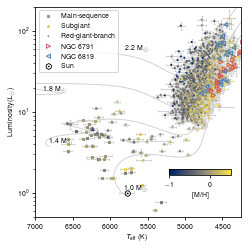

In [14]:
fig, axes = plt.subplots(figsize=mnras_size(ratio=1.,column='one'), nrows=1, ncols=1, 
                         squeeze=False, constrained_layout=True) #, gridspec_kw={'wspace':0.5,'hspace':0.5}
axes = axes.reshape(-1)

import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=0.5)
cmap = 'cividis'
msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

sunstyle = {'marker':'$\\odot$', 's':msize+32, 'edgecolor':'k', 'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha, 'norm':norm}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch', 'alpha':alpha, 'norm':norm}
msstyle = {'marker':'s', 'cmap': cmap, 's':msize, 'label':'Main-sequence', 'alpha':alpha, 'norm':norm}
sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha, 'norm':norm}
ngc6791style = {'marker':'>',  's':msize+12, 'edgecolor':red, 'facecolor':'none', 'label':'NGC 6791', 'alpha':alpha, 'zorder':10, 'norm':norm}
ngc6819style = {'marker':'<',  's':msize+12, 'edgecolor':blue, 'facecolor':'none', 'label':'NGC 6819', 'alpha':alpha, 'zorder':10, 'norm':norm}
errorstyles = {'linestyle':'none', 'ecolor':'lightgray', 'capsize':1, 'elinewidth':1, 'zorder':-10}

rg = np.isin(stars['stage'],['rgb','lsg'])
sg = np.isin(stars['stage'],['esg', ])
sun = np.isin(stars['names'],['Sun'])
ms = np.isin(stars['stage'],['ms']) & (~sun)
ngc6791 = np.isin(stars['names'], ['ngc6791'])
ngc6819 = np.isin(stars['names'], ['ngc6819'])

idxes = [ms, sg, rg, ngc6791, ngc6819]
styles = [msstyle, sgstyle, rgstyle, ngc6791style, ngc6819style]

for i in range(5):
    if i<=2:
        styles[i]['c'] = stars.loc[idxes[i], '[M/H]']
    else:
        pass #styles[i]['c'] = 'k'
#     axes[0].scatter(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'], rasterized=True,  **styles[i])
#     axes[0].errorbar(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'],
#                     xerr = stars.loc[idxes[i], 'e_Teff'], yerr=stars.loc[idxes[i], 'e_Dnu'], rasterized=True, 
#                      **errorstyles)
    axes[-1].scatter(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'lum_J'], rasterized=True, **styles[i])
    axes[-1].errorbar(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'lum_J'],
                    xerr = stars.loc[idxes[i], 'e_Teff'], yerr=stars.loc[idxes[i], 'e_lum_J'],rasterized=True, 
                     **errorstyles)
    
# axes[0].scatter(stars.loc[sun,'Teff'], stars.loc[sun,'Dnu'], c='k',**sunstyle)
# axes[0].errorbar(stars.loc[sun,'Teff'], stars.loc[sun,'Dnu'],xerr=stars.loc[sun,'e_Teff'], yerr=stars.loc[sun,'e_Dnu'], **errorstyles)
axes[-1].scatter(stars.loc[sun,'Teff'], stars.loc[sun,'lum_J'], c='k',**sunstyle)
axes[-1].errorbar(stars.loc[sun,'Teff'], stars.loc[sun,'lum_J'],xerr=stars.loc[sun,'e_Teff'], yerr=stars.loc[sun,'e_lum_J'], **errorstyles)

# axes[0].axis([7000, 4250, 250., 2.])
# axes[0].set_yscale('log')
# axes[0].set_xlabel('$T_{\\rm{eff}}$  (K)')
# axes[0].set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)')
# axes[0].legend(fontsize=fontsize)

axes[-1].axis([7000, 4250, 0.5, 200.])
axes[-1].set_yscale('log')
axes[-1].set_xlabel('$T_{\\rm{eff}}$  (K)')
axes[-1].set_ylabel('Luminosity ($L_{\\odot}$)')
axes[-1].legend(fontsize=fontsize, loc='upper left')

# get tracks 
params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
Zsun, Xsun = 0.0134, 0.7381
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
masses = np.array([1.0, 1.4, 1.8, 2.2])
e_mass = 0.01
Yinit, e_Yinit = 0.290, 0.01
amlt, e_amlt = 1.7, 0.02
feh, e_feh = 0., 0.01

indexes = []
for mass in masses:
    metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
    (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
    (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
    (params['feh']-feh)**2.0/e_feh**2.0 
    indexes.append(np.argmin(metric))
    
indexes = [6167, 6891, 3897, 1093]
for i in indexes:
    data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
#     axes[0].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)
    axes[-1].plot(data['Teff'][idx], data['luminosity'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)
    
    idx = idx & (data['Teff'][:]<6900)
#     axes[0].text(data['Teff'][idx][0], data['delta_nu'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)
    if not i == 1093:
        axes[-1].text(data['Teff'][idx][0], data['luminosity'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)
    else:
        axes[-1].text(5800, data['luminosity'][idx][0]*1., '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)
    

for ax in axes:
    cax = ax.inset_axes([0.65, 0.2, 0.3, 0.03], transform=ax.transAxes)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ax=ax, orientation='horizontal').set_label('[M/H]')


# plt.subplots_adjust()
filename = 'Fig.1_HRD.pdf'

plt.savefig(filename)
os.system(to_overleaf(filename, 'figures'))